In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

from skimage import color, io
from skimage.transform import rescale
import time
import tqdm

In [2]:
def generate_object(num_angles=3, convex=True):
    angles = np.random.random(num_angles).cumsum()
    angles = (angles / angles[-1]) * np.pi * 2
    if convex:
        xs, ys = np.cos(angles) * 2, np.sin(angles) * 2
    else:
        coefs = np.random.random(num_angles) + 1
        xs, ys = coefs * np.cos(angles), coefs * np.sin(angles)
    for i in range(len(xs)):
        ip1, ip2 = (i + 1) % len(xs), (i + 2) % len(xs)
        vec1 = np.array([xs[ip1]-xs[i], ys[ip1]-ys[i]])
        vec2 = np.array([xs[ip2]-xs[ip1], ys[ip2]-ys[ip1]])
        cos = np.inner(vec1, vec2) / \
            (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        #sin_sign = np.cross(vec1, vec2)
        dist = np.linalg.norm(vec1)
        if np.abs(cos) > 0.89 or dist < 0.5:
            return generate_object(num_angles, convex)
    return xs, ys

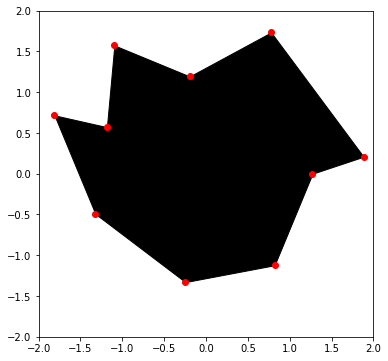

In [3]:
xs, ys = generate_object(num_angles=10, convex=False)

N = np.stack((xs, ys)).transpose(1, 0)
patches = [Polygon(N)]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
p = PatchCollection(patches, alpha=1, color="k")
ax.add_collection(p)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
ax.plot(xs, ys, "ro", color="r")
plt.show()

In [4]:
xs, ys = generate_object(num_angles=10, convex=False)

N = np.stack((xs, ys)).transpose(1, 0)
patches = [Polygon(N)]
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
p = PatchCollection(patches, alpha=1, color="b")
#ax.add_collection(p)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
ax.scatter(xs, ys, color="k", s=8)
plt.axis("off")
plt.savefig("fig.png", dpi=300)
plt.close(fig)

img = color.rgb2gray(io.imread("fig.png"))
img = rescale(img, 0.5)

/home/ohrinchuk/miniconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/ohrinchuk/miniconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ohrinchuk/miniconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [4]:
images = [[] for i in range(8)]
labels = [[] for i in range(8)]
for j in tqdm.tqdm(range(8)):
    for i in range(3200):
        xs, ys = generate_object(num_angles=j+3, convex=False)
        N = np.stack((xs, ys)).transpose(1, 0)
        patches = [Polygon(N)]

        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        p = PatchCollection(patches, alpha=1, color="k")
        ax.add_collection(p)

        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.axis("off")
        plt.savefig("fig.png", dpi=300)
        plt.close(fig)

        img = color.rgb2gray(io.imread("fig.png"))
        img = rescale(img, 0.5)
        images[j].append(1-img)
        
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        ax.scatter(xs, ys, color="k", s=8)
        plt.axis("off")
        plt.savefig("fig.png", dpi=300)
        plt.close(fig)

        img = color.rgb2gray(io.imread("fig.png"))
        img = rescale(img, 0.5)
        img_ = (img < 0.01).astype(np.int)
        labels[j].append(img_)

  0%|          | 0/8 [00:00<?, ?it/s]/home/ohrinchuk/miniconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/ohrinchuk/miniconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ohrinchuk/miniconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 8/8 [1:56:58<00:00, 868.44s/it]


NameError: name 'images' is not defined

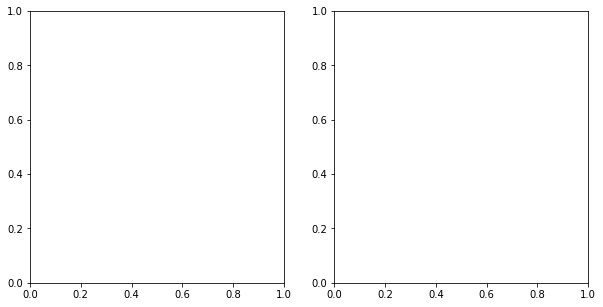

In [5]:
idx = 120
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[-1][idx], cmap="gray")
ax[1].imshow(labels[-1][idx], cmap="gray")

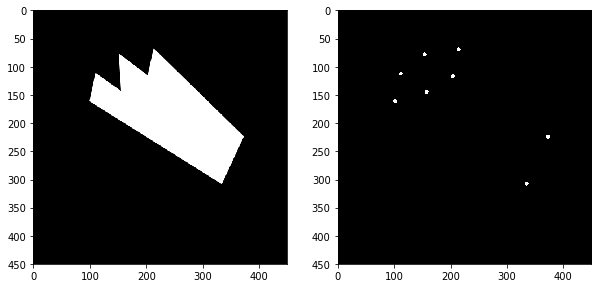

In [45]:
idx = 120
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[-3][idx], cmap="gray")
ax[1].imshow(labels[-3][idx], cmap="gray")

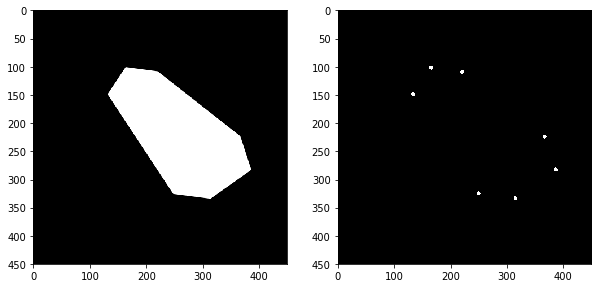

In [46]:
idx = 120
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[-4][idx], cmap="gray")
ax[1].imshow(labels[-4][idx], cmap="gray")

In [ ]:
data = np.array(images).astype(np.bool)
labl = np.array(labels).astype(np.bool)

In [8]:
train = data[:,:3000].reshape(-1, 450, 450)
labl_ = labl[:,:3000].reshape(-1, 450, 450)
labels_ = np.repeat(np.arange(8), 3000)
np.savez("data/segment3k/train.npz", data=train, labels=labels_, masks=labl_)

test = data[:,3000:3200].reshape(-1, 450, 450)
labl_ = labl[:,3000:3200].reshape(-1, 450, 450)
labels_ = np.repeat(np.arange(8), 200)
np.savez("data/segment3k/test.npz", data=test, labels=labels_, masks=labl_)

In [6]:
ddt = np.load("data/segment/test.npz")["data"]

In [7]:
ddt.shape

(1600, 450, 450)

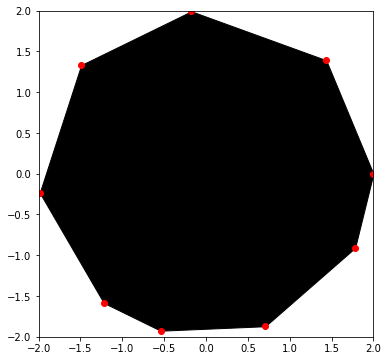

In [8]:
xs, ys = generate_object(num_angles=9, convex=True)

N = np.stack((xs, ys)).transpose(1, 0)
patches = [Polygon(N)]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
p = PatchCollection(patches, alpha=1, color="k")
ax.add_collection(p)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot(xs, ys, "ro")
plt.show()

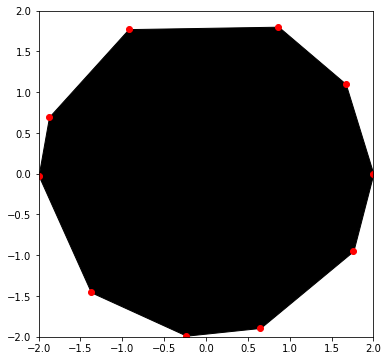

In [9]:
xs, ys = generate_object(num_angles=10, convex=True)

N = np.stack((xs, ys)).transpose(1, 0)
patches = [Polygon(N)]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
p = PatchCollection(patches, alpha=1, color="k")
ax.add_collection(p)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot(xs, ys, "ro")
plt.show()

In [58]:
images = [[] for i in range(8)]
for j in tqdm.tqdm(range(8)):
    for i in range(1200):
        xs, ys = generate_object(num_angles=j+3, convex=False)
        N = np.stack((xs, ys)).transpose(1, 0)
        patches = [Polygon(N)]

        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        p = PatchCollection(patches, alpha=1, color="k")
        ax.add_collection(p)

        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.axis("off")
        plt.savefig("fig.png", dpi=300)
        plt.close(fig)

        img = color.rgb2gray(io.imread("fig.png"))
        img = rescale(img, 0.5)
        images[j].append(1-img)

100%|██████████| 8/8 [21:52<00:00, 165.06s/it]


In [9]:
tr = np.load("data/segment3k/test.npz")
tr_dat, tr_lab = tr["data"], tr["labels"]

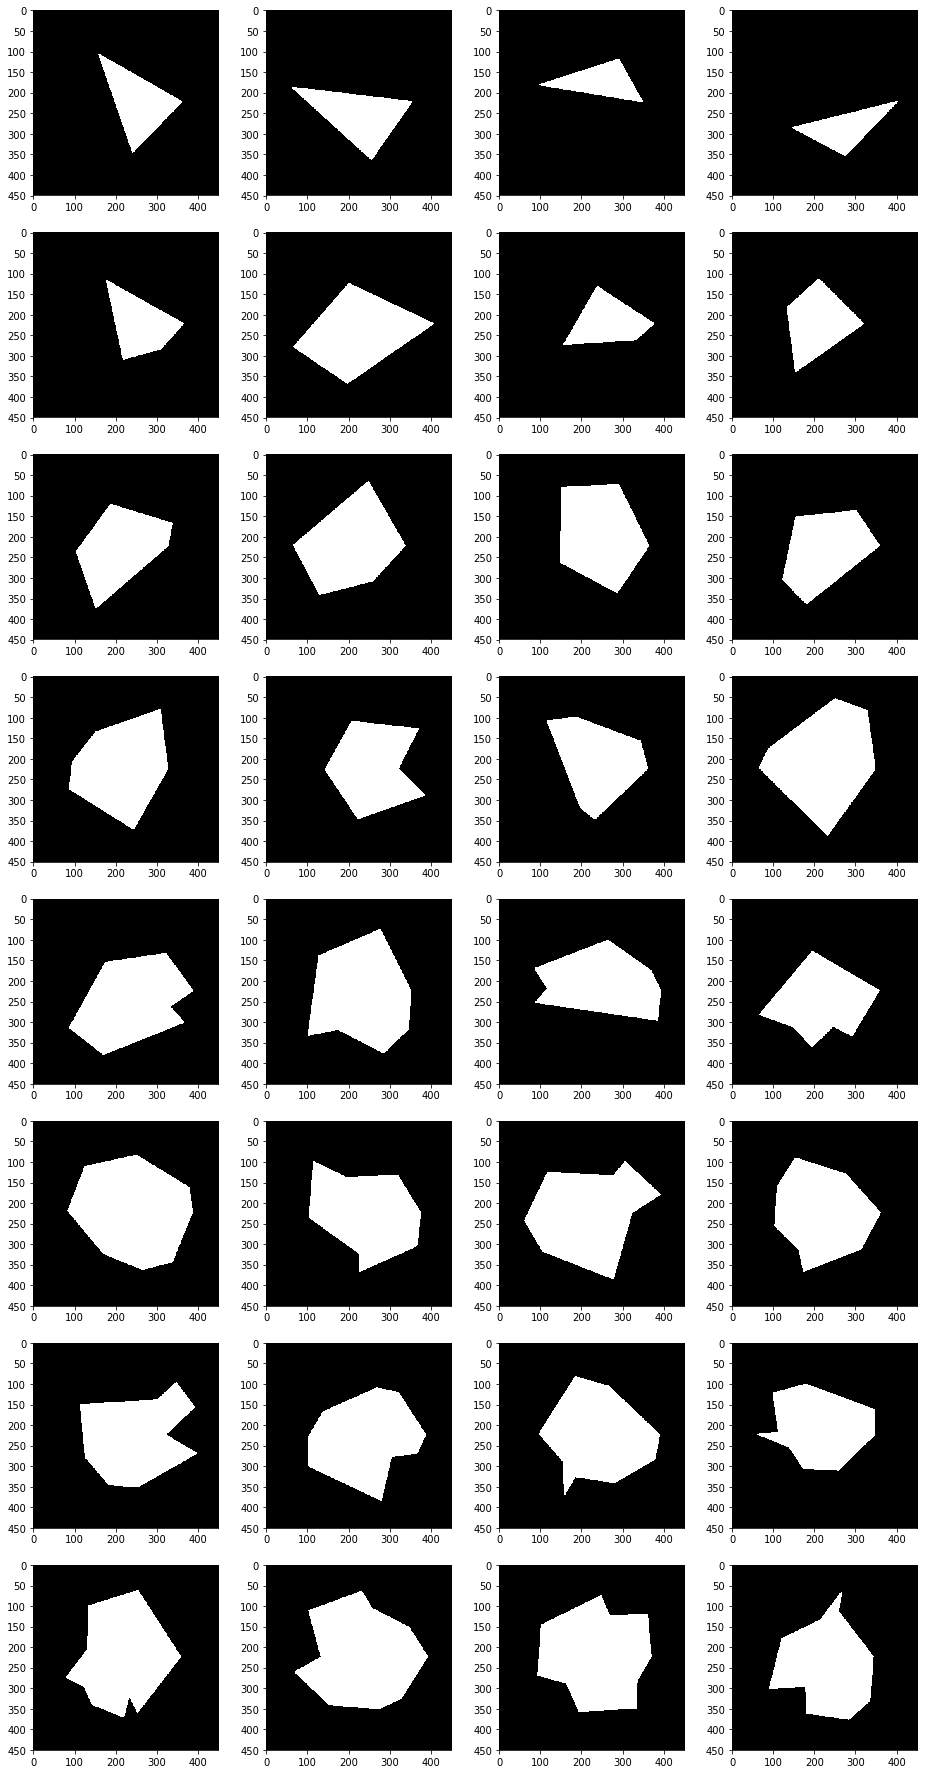

In [10]:
fig, ax = plt.subplots(8, 4, figsize=(16, 32))
for i in range(8):
    for j in range(4):
        idx = np.random.randint(200) + 200 * i
        ax[i,j].imshow(tr_dat[idx], cmap="gray")

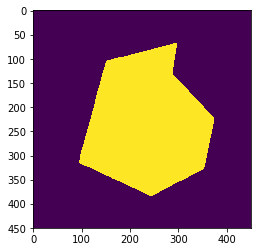

In [11]:
plt.imshow(tr_dat[900])

In [277]:
def get_neighbors(i, j):
    candidates = [
        (0, 1), (1, 1), (1, 0), (1, -1),
        (0, -1), (-1, -1), (-1, 0), (-1, 1)]
    xs, ys = [], []
    for p in candidates:
        x, y = i + p[0], j + p[1]
        if (x >= 0 and x < 450 and y >= 0 and y < 450):
            xs.append(x)
            ys.append(y)
    return xs, ys

In [331]:
img = tr_dat[900]
new_img = np.zeros_like(img)
start_point = None
for i in range(450):
    for j in range(450):
        ns = get_neighbors(i, j)
        if img[ns].sum() < len(ns[0]) and img[ns].sum() > 3:
            new_img[i, j] = 1
            if start_point is None:
                start_point = (i, j)

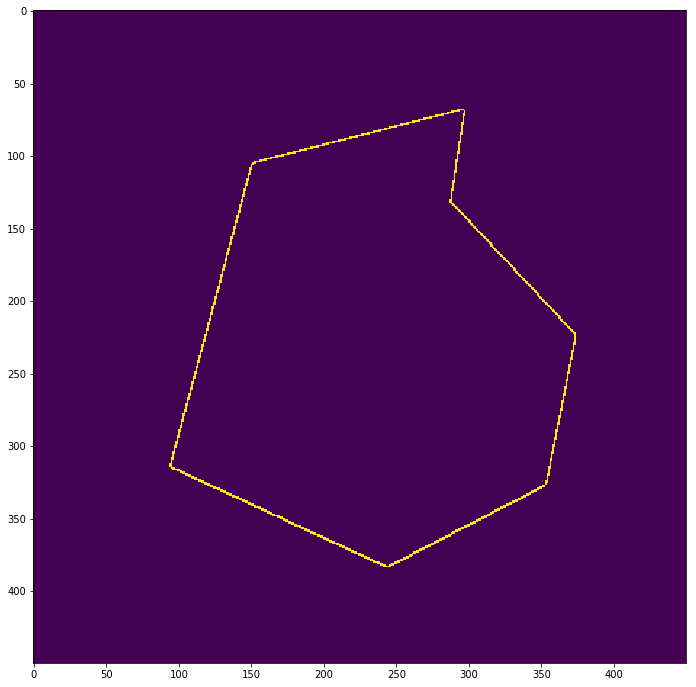

In [332]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(new_img)

In [340]:
1442/1600

0.90125

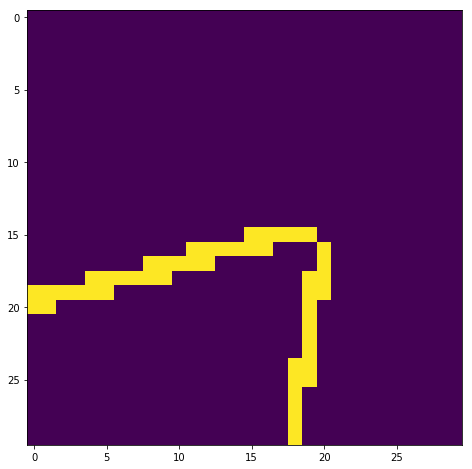

In [333]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
p1, p2 = start_point
ax.imshow(new_img[p1-15:p1+15,p2-15:p2+15])

In [338]:
def get_point_list(img, start_point):
    img_ = np.copy(img).astype(np.int)
    p = start_point
    for i in range(379):
        img_[p] = 2
        idx = 0
        ns = get_neighbors(*p)
        while img_[ns[0][idx], ns[1][idx]] != 1:
            idx += 1
        p = (ns[0][idx], ns[1][idx])
        #print (p)
    return img_

In [339]:
img_ = get_point_list(new_img, start_point)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_)

IndexError: list index out of range

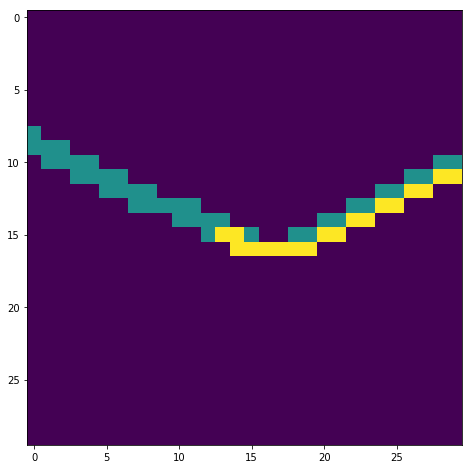

In [336]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
p1, p2 = 382, 242#start_point
ax.imshow(img_[p1-15:p1+15,p2-15:p2+15])

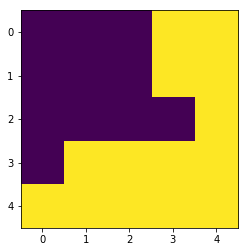

In [423]:
plt.imshow(img[136:141, 195:200])

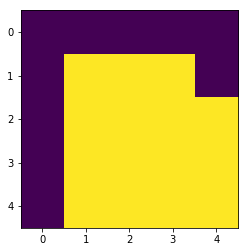

In [424]:
plt.imshow(img[88:93, 190:195])

(array([433., 218., 301., 146., 192., 154., 190., 181.,  63., 256.,  64.,
        185., 181.,  62., 255.,  61., 185., 182., 148., 189., 140., 296.,
        627.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <a list of 23 Patch objects>)

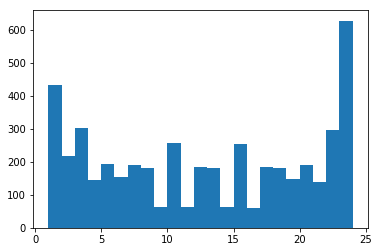

In [388]:
plt.hist(stats, bins=x**2-2)

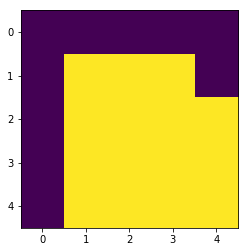

In [382]:
plt.imshow(img[88:93, 190:195])

In [60]:
data = np.array(images).astype(np.bool)
train = data[:,:1000].reshape(-1, 450, 450)
labels = np.repeat(np.arange(8), 1000)
np.savez("data/convex_clean_train.npz", data=train, labels=labels)

test = data[:,1000:1200].reshape(-1, 450, 450)
labels = np.repeat(np.arange(8), 200)
np.savez("data/convex_clean_test.npz", data=test, labels=labels)

In [20]:
data = np.load("data.npz")["data"]
train = data[:7, :1000].reshape(-1, 225, 225)
labels = np.repeat(np.arange(7), 1000)
np.savez("data/train.npz", data=train, labels=labels)

test = data[:7, 1000:1200].reshape(-1, 225, 225)
labels = np.repeat(np.arange(7), 200)
np.savez("data/test.npz", data=test, labels=labels)

In [ ]:
np.savez("data.npz", data=ims)

In [ ]:
images[-1][3]

In [15]:
tr = np.load("data/clean_train.npz")["data"]
tr.shape

(8000, 450, 450)

In [26]:
np.savez("small_data.npz", train=train, test=test)

In [85]:
test = np.load("small_data.npz")["test"]
labels = np.repeat(np.arange(7), 200)

In [87]:
np.savez("data/test.npz", data=test.reshape(-1, 225, 225), labels=labels)

In [100]:
t = np.load("data/train.npz")["data"]

In [101]:
t.shape

(21000, 225, 225)

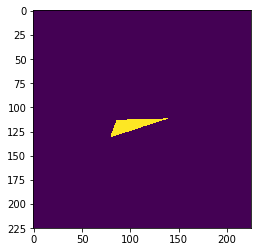

In [65]:
plt.imshow(t[0])

In [64]:
t.shape

(7000, 225, 225)

In [35]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [180]:
class ResBlock(nn.Module):

    def __init__(self, inplanes, planes, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3,
            stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3,
            stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        print (out.shape)
        out = self.bn1(out)
        print (out.shape)
        out = self.relu(out)
        print (out.shape)
        out = self.conv2(out)
        print (out.shape)
        out = self.bn2(out)
        print (out.shape)
        out += identity
        print (out.shape)
        out = self.relu(out)
        out = self.avgpool(out)
        print (out.shape)

In [181]:
bb = ResBlock(1, 32)

In [182]:
a = torch.Tensor((np.random.random((16, 1, 100, 100))))

In [183]:
bb(a)

torch.Size([16, 32, 100, 100])
torch.Size([16, 32, 100, 100])
torch.Size([16, 32, 100, 100])
torch.Size([16, 32, 100, 100])
torch.Size([16, 32, 100, 100])
torch.Size([16, 32, 100, 100])
torch.Size([16, 32, 1, 1])
